# Toy 2-layer NN

In [35]:
# Setup codes

import numpy as np
import matplotlib.pyplot as plt

from builtins import range
from builtins import object

from past.builtins import xrange #pip install future # in terminal


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """
    
    
    # Initialize the NN
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; Shape (D, H)
        b1: First layer biases; Shape (H,)
        W2: Second layer weights; Shape (H, C)
        b2: Second layer biases; Shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization penalty) 
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        # Use Relu as the non-linearity function
        scores = np.maximum(X.dot(W1) + b1, 0).dot(W2) + b2


        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        exp_scores = np.exp(scores)
        vector = np.sum(exp_scores,axis=1)
        exp_scores_norm = exp_scores/vector[:,None]
        loss = np.sum(-np.log(exp_scores_norm[np.arange(N),np.array(y)]))/N
        
        # Add regularization loss
        loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))

        # Backward pass: compute gradients
        grads = {}
        
        dev = np.zeros(scores.shape)
        dev[np.arange(N),np.array(y)] = 1
        dlossdscores = (exp_scores_norm - dev)/N   # N x C
        
        grads['b2'] = np.sum(dlossdscores, axis = 0)     # C x 1
        grads['W2'] = np.maximum(X.dot(W1) + b1, 0).T.dot(dlossdscores) + 2*reg*W2          # H x C
        grads['b1'] = np.sum(dlossdscores.dot(W2.T)*(X.dot(W1) + b1 >0),axis = 0) # H x 1
        grads['W1'] = X.T.dot(dlossdscores.dot(W2.T)*(X.dot(W1) + b1 >0))+ 2*reg*W1   
       

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using SGD.

        Inputs:
        - X: Shape (N, D) 
        - y: Shape (N, )
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val, ) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            mask  = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[mask]
            y_batch = y[mask]

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            # Gradient descent 
            self.params['b1']  += -learning_rate*grads['b1']
            self.params['W1']  += -learning_rate*grads['W1']
            self.params['b2']  += -learning_rate*grads['b2']
            self.params['W2']  += -learning_rate*grads['W2']


            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: Shape (N, D)

        Returns:
        - y_pred: Shape (N,)
        """

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        scores  =  np.maximum(X.dot(W1) + b1, 0).dot(W2) + b2
        y_pred  =  np.argmax(scores,axis = 1)

        return y_pred


# Toy data example

In [37]:
# Create a small net and some toy data to check your implementations.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

## Forward pass: compute scores
Calculate the class scores, the loss, and the gradients on the parameters. 


In [38]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


## Forward pass: compute loss

Calculate the model loss and regularizaion loss.

In [39]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


## Backward pass: compute gradient

Compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`.

In [40]:
import sys
sys.path.append('/classes/2080001_spr2022/')

In [41]:
from gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# The difference between the numeric and analytic gradients should be less than 
# 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 4.447646e-11
W2 max relative error: 3.440708e-09
b1 max relative error: 2.738421e-09
W1 max relative error: 3.561318e-09


## Combine the above: Training

Use SGD to train the NN. The training loss should less than 0.2.

Final training loss:  0.017149607938732048


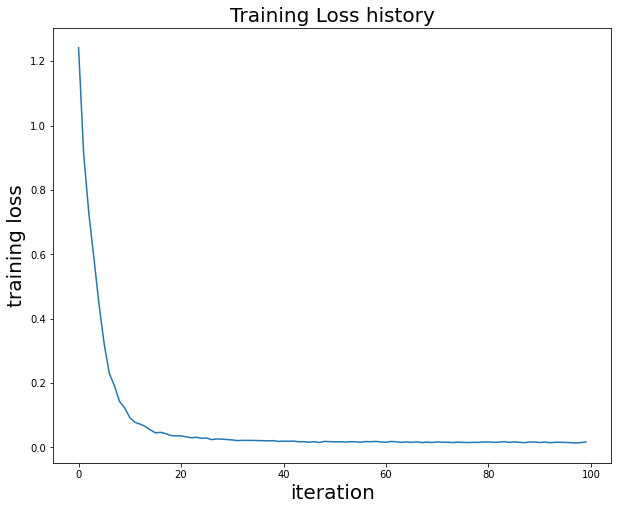

In [42]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration',size = 20)
plt.ylabel('training loss',size = 20)
plt.title('Training Loss history', size = 20)
plt.show()

# CIFAR10 Classfication

Now we use CIFAR10 as the real data example.

In [43]:
from data_utils import load_CIFAR10

def get_CIFAR10_data_toy(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/classes/2080001_spr2022/Data/cifar-10-data'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [44]:
# Load data
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data_toy()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


## Training

### Method: SGD with exponential decay learning rate


In [45]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302954
iteration 100 / 1000: loss 2.302550
iteration 200 / 1000: loss 2.297648
iteration 300 / 1000: loss 2.259602
iteration 400 / 1000: loss 2.204170
iteration 500 / 1000: loss 2.118565
iteration 600 / 1000: loss 2.051535
iteration 700 / 1000: loss 1.988466
iteration 800 / 1000: loss 2.006591
iteration 900 / 1000: loss 1.951473
Validation accuracy:  0.287


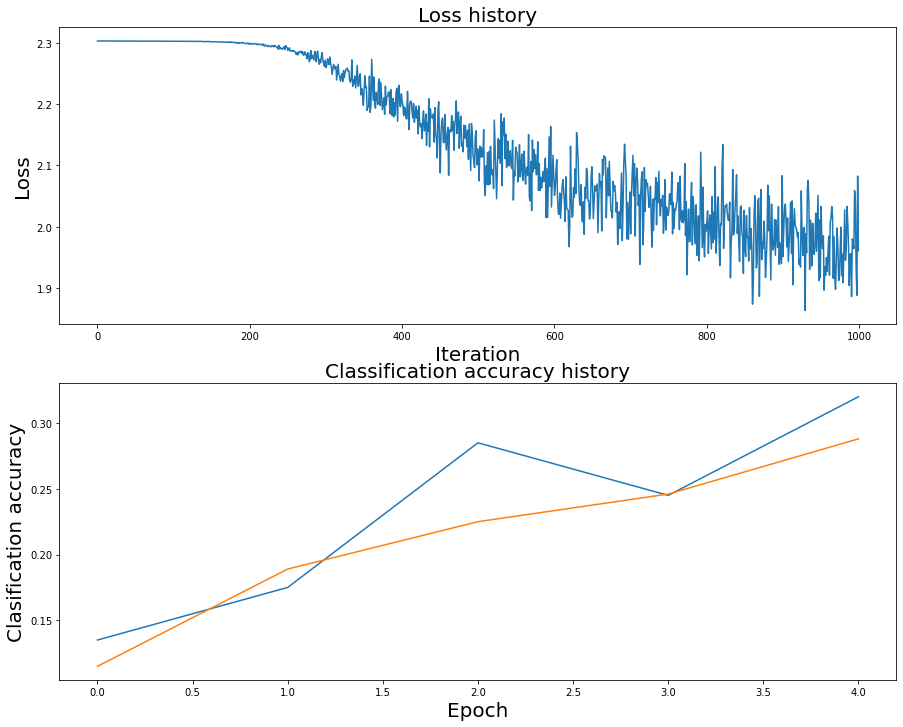

In [46]:
# Plot the loss function and train / validation accuracies
plt.figure(figsize = (15,12))
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history', size = 20)
plt.xlabel('Iteration', size = 20)
plt.ylabel('Loss',size = 20)

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history', size = 20)
plt.xlabel('Epoch', size = 20)
plt.ylabel('Clasification accuracy', size = 20)
plt.show()

## Tuning


**What's wrong?**. 

The loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model has low capacity, and that we should increase its size. 

On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.



**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including 
+ hidden layer size, 
+ learning rate, 
+ numer of training epochs,
+ regularization strength;
+ learning rate decay.

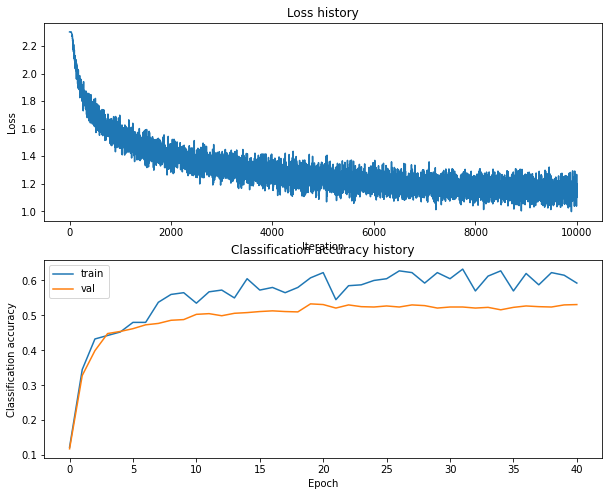

lr 5.000000e-04 reg 5.000000e-02 val accuracy: 0.528000


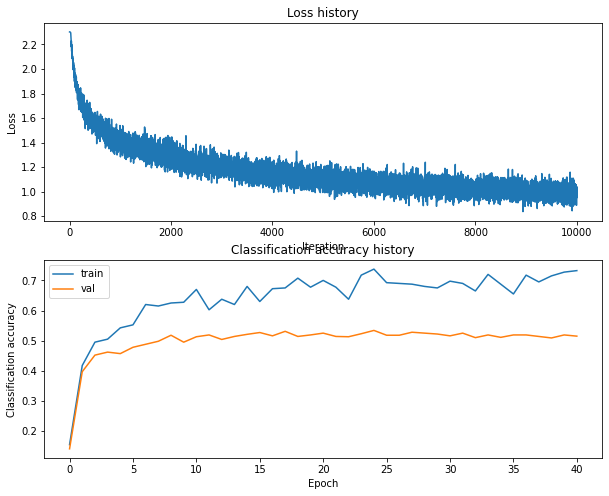

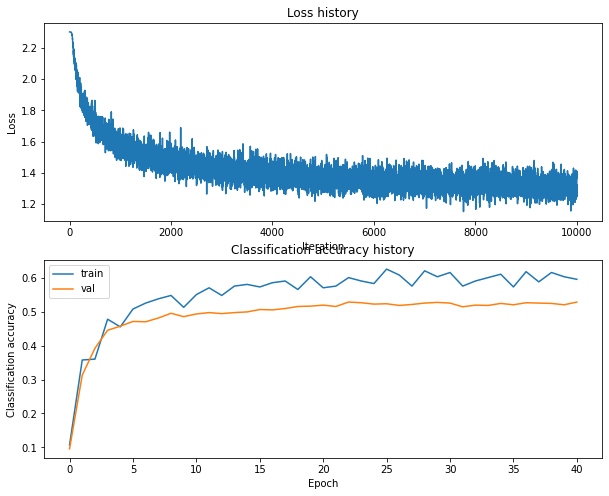

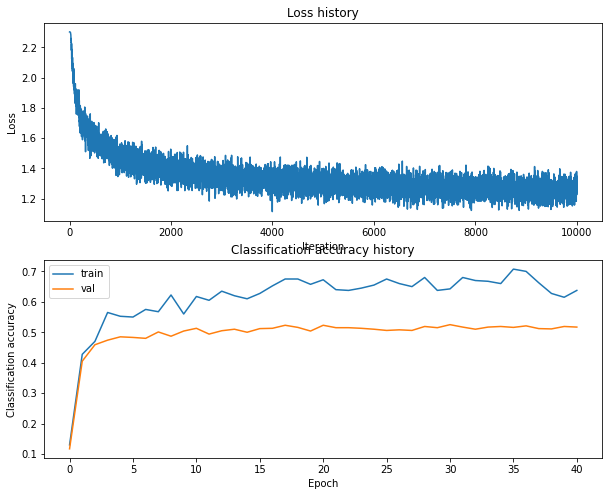

lr 5.000000e-04 reg 5.000000e-02 train accuracy: 0.620122 val accuracy: 0.528000
lr 5.000000e-04 reg 2.500000e-01 train accuracy: 0.594796 val accuracy: 0.521000
lr 1.000000e-03 reg 5.000000e-02 train accuracy: 0.691796 val accuracy: 0.516000
lr 1.000000e-03 reg 2.500000e-01 train accuracy: 0.644592 val accuracy: 0.525000
best validation accuracy achieved during cross-validation: 0.528000


In [47]:
best_net = None # store the best model into this 

input_size = 32 * 32 * 3
hidden_size = 75
num_classes = 10
results = {}
best_val = -1

learning_rates = [5e-4,1e-3]
regularization_strengths = [0.05,0.25]


hyper_params = [(lr, reg) for j, reg  in enumerate(regularization_strengths) for i, lr in enumerate(learning_rates)]

for lr, reg_s in hyper_params:
    
    
    net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
    stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=10000, batch_size=400,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg_s, verbose=False)

    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.legend()
    plt.show()
   
    y_train_pred = net.predict(X_train)
    y_val_pred = net.predict(X_val)
    results.update({(lr, reg_s): (np.mean(y_train == y_train_pred),np.mean(y_val == y_val_pred))})
    new_val  =  np.mean(y_val == y_val_pred)
    if new_val>best_val:
        best_val = new_val
        best_net = net
        print('lr %e reg %e val accuracy: %f' % (lr, reg_s, new_val))


    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

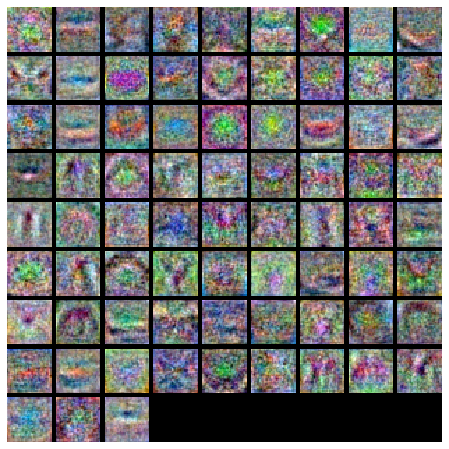

In [48]:
from vis_utils import visualize_grid

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

# visualize the weights of the best network
show_net_weights(best_net)

In [49]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.53


#  Multi-layer NN

Now we have finished the top layer, and we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```


## Affine layer: foward

In [50]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). 
    Reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    
    out = np.reshape(x,(x.shape[0],np.prod(x.shape[1:]))).dot(w) + b
    

    cache = (x, w, b)
    return out, cache

In [51]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


## Affine layer: backward

In [52]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache

    db = np.sum(dout, axis = 0)   
    dw = np.reshape(x,(x.shape[0],np.prod(x.shape[1:]))).T.dot(dout)
    dx = dout.dot(w.T).reshape(x.shape) 
    
    return dx, dw, db

In [53]:
from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array


# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


##  ReLU activation: forward

In [54]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).
    """
    out = np.maximum(x, 0)
    cache = x
    return out, cache

In [55]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


## ReLU activation: backward

In [56]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of ReLUs.

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache

    dx = dout*(x>0)
    return dx

In [57]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Loss layers: Softmax

In [58]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,)
    
    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

In [59]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Multilayer network

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [60]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
                 reg=0.0,
                 weight_scale=1e-2, dtype=np.float32):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.

        """
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        if len(hidden_dims)>0:
            self.params['W1'] = weight_scale * np.random.randn(input_dim, hidden_dims[0])
            self.params['b1'] = np.zeros(hidden_dims[0])
        
        for idx, dim in enumerate(hidden_dims):
            if idx < len(hidden_dims)-1:
                self.params['W' + str(2 + idx)] = weight_scale * np.random.randn(dim, hidden_dims[idx + 1])
                self.params['b' + str(2 + idx)] = np.zeros(hidden_dims[idx + 1])
            else:
                self.params['W' + str(2 + idx)] = weight_scale * np.random.randn(hidden_dims[idx], num_classes)
                self.params['b' + str(2 + idx)] = np.zeros(num_classes)


        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        out = X
        for la in range(self.num_layers-1):
            a, _      = affine_forward(out, self.params['W'+str(la+1)], self.params['b'+str(la+1)])
            out, _    = relu_forward(a)
            

            
        scores, _ = affine_forward(out,
                                   self.params['W'+str(self.num_layers)],self.params['b'+str(self.num_layers)])


        # If test mode return early
        if mode == 'test':
            return scores

        out = X
        a=[]
        affine_cache = []
        relu_cache   = []
       
            
        for la in range(self.num_layers-1):
            a, a_cache    = affine_forward(out, self.params['W'+str(la+1)], self.params['b'+str(la+1)])
            affine_cache.append(a_cache)
                
            out, r_cache    = relu_forward(a)
            relu_cache.append(r_cache)
            
   
        scores, cache  = affine_forward(out, self.params['W'+str(self.num_layers)], self.params['b'+str(self.num_layers)])
        loss, dx       = softmax_loss(scores, y)
        
        
    
        da, dW, db  = affine_backward(dx, cache)
        grads['W'+str(self.num_layers)] = dW
        grads['b'+str(self.num_layers)] = db
            
        for la in reversed(range(self.num_layers-1)):            
            
            dr = relu_backward(da, relu_cache[la])
            
            da, dW, db = affine_backward(dr, affine_cache[la])
            grads['W'+ str(la+1)] = dW
            grads['b'+ str(la+1)] = db
            
        for la in range(self.num_layers):
            loss += 1/2*self.reg * np.sum(self.params['W'+ str(la+1)] * self.params['W'+ str(la+1)])     
            grads['W'+ str(la+1)]  +=  self.reg*self.params['W'+ str(la+1)] 

        return loss, grads


In [61]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 3.24e-06
W2 relative error: 2.53e-05
W3 relative error: 3.53e-07
b1 relative error: 1.87e-07
b2 relative error: 4.32e-07
b3 relative error: 4.50e-06
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.25e-03
W2 relative error: 4.42e-05
W3 relative error: 8.82e-05
b1 relative error: 1.61e-07
b2 relative error: 1.72e-09
b3 relative error: 4.50e-06


In [62]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
from data_utils import get_CIFAR10_data

data = get_CIFAR10_data()


(Iteration 1 / 40) loss: 118.014768
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.106000
(Epoch 1 / 20) train acc: 0.100000; val_acc: 0.119000
(Epoch 2 / 20) train acc: 0.200000; val_acc: 0.091000
(Epoch 3 / 20) train acc: 0.360000; val_acc: 0.110000
(Epoch 4 / 20) train acc: 0.600000; val_acc: 0.112000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.124000
(Iteration 11 / 40) loss: 4.282706
(Epoch 6 / 20) train acc: 0.880000; val_acc: 0.122000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.121000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.121000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.118000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.119000
(Iteration 21 / 40) loss: 0.002728
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.119000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.119000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.120000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.116000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.114000
(Iteration 31 / 40) loss

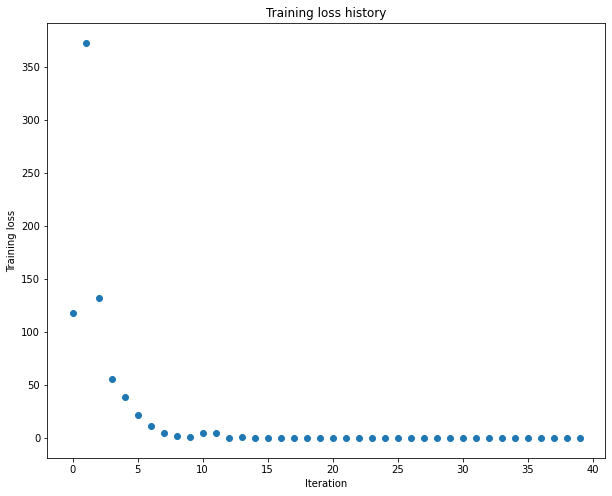

In [63]:
from solver import Solver

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 2e-3  # Experiment with this!
weight_scale = 1*1e-1   # Experiment with this!
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.

Run the following to check your implementation. You should see errors less than e-8.

In [64]:
from optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


running with  sgd
(Iteration 1 / 200) loss: 2.541697
(Epoch 0 / 5) train acc: 0.091000; val_acc: 0.105000
(Iteration 11 / 200) loss: 2.312049
(Iteration 21 / 200) loss: 2.157304
(Iteration 31 / 200) loss: 2.111563
(Epoch 1 / 5) train acc: 0.256000; val_acc: 0.226000
(Iteration 41 / 200) loss: 2.201790
(Iteration 51 / 200) loss: 2.028876
(Iteration 61 / 200) loss: 2.052878
(Iteration 71 / 200) loss: 2.053159
(Epoch 2 / 5) train acc: 0.306000; val_acc: 0.269000
(Iteration 81 / 200) loss: 2.019368
(Iteration 91 / 200) loss: 2.078111
(Iteration 101 / 200) loss: 2.044612
(Iteration 111 / 200) loss: 1.898157
(Epoch 3 / 5) train acc: 0.306000; val_acc: 0.283000
(Iteration 121 / 200) loss: 2.005204
(Iteration 131 / 200) loss: 1.806351
(Iteration 141 / 200) loss: 1.877307
(Iteration 151 / 200) loss: 1.740371
(Epoch 4 / 5) train acc: 0.363000; val_acc: 0.297000
(Iteration 161 / 200) loss: 1.764304
(Iteration 171 / 200) loss: 1.863157
(Iteration 181 / 200) loss: 1.875031
(Iteration 191 / 200) los

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

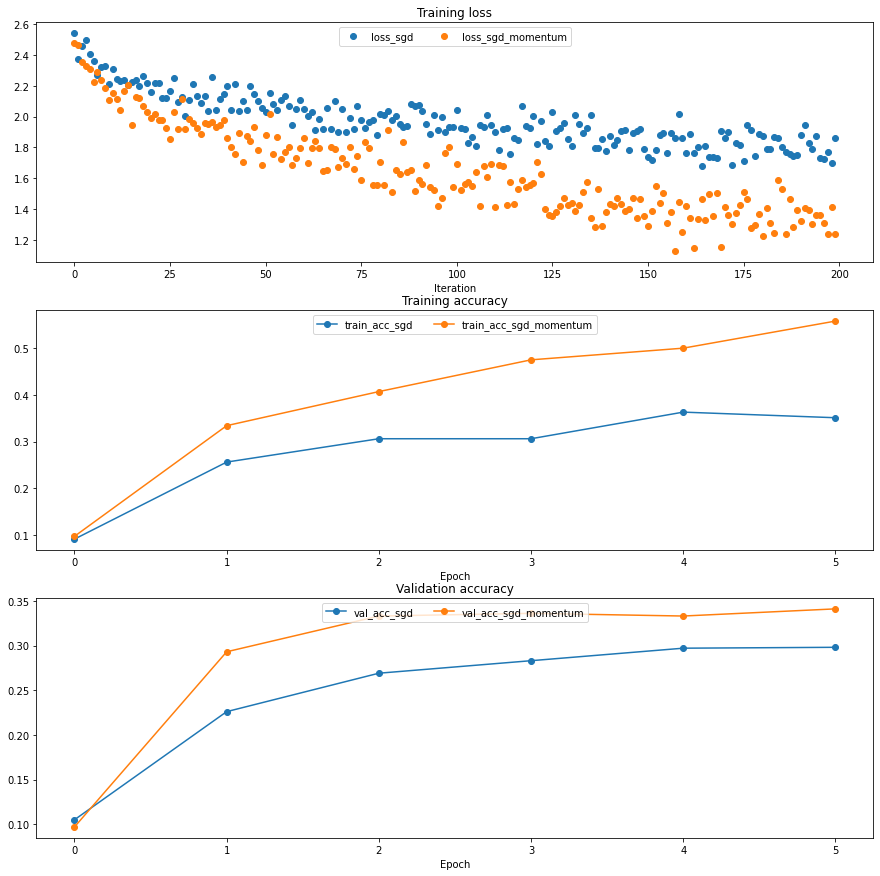

In [65]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. 

(Iteration 1 / 1960) loss: 2.309149
(Epoch 0 / 20) train acc: 0.103000; val_acc: 0.102000
(Epoch 1 / 20) train acc: 0.113000; val_acc: 0.079000
(Iteration 101 / 1960) loss: 2.308089
(Epoch 2 / 20) train acc: 0.109000; val_acc: 0.098000
(Iteration 201 / 1960) loss: 2.307355
(Epoch 3 / 20) train acc: 0.101000; val_acc: 0.098000
(Iteration 301 / 1960) loss: 2.306598
(Epoch 4 / 20) train acc: 0.132000; val_acc: 0.158000
(Iteration 401 / 1960) loss: 2.300881
(Epoch 5 / 20) train acc: 0.191000; val_acc: 0.205000
(Iteration 501 / 1960) loss: 2.084033
(Epoch 6 / 20) train acc: 0.226000; val_acc: 0.240000
(Iteration 601 / 1960) loss: 1.934724
(Epoch 7 / 20) train acc: 0.301000; val_acc: 0.294000
(Iteration 701 / 1960) loss: 1.715395
(Epoch 8 / 20) train acc: 0.366000; val_acc: 0.366000
(Iteration 801 / 1960) loss: 1.705425
(Epoch 9 / 20) train acc: 0.439000; val_acc: 0.440000
(Iteration 901 / 1960) loss: 1.523170
(Epoch 10 / 20) train acc: 0.455000; val_acc: 0.481000
(Iteration 1001 / 1960) los

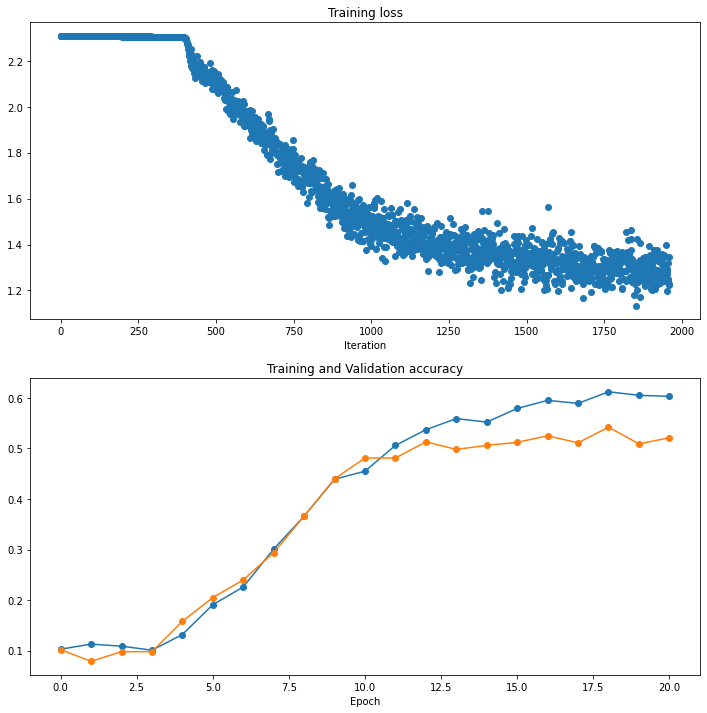

In [66]:
best_model = None

weight_scale = 10*2*1e-4   # Experiment with this!
learning_rate = 9*1e-3  # Experiment with this!
model = FullyConnectedNet([100,100,100], reg = 1*1e-2,
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, data,
                print_every=100, num_epochs=20, batch_size=500, 
                update_rule='sgd_momentum',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

best_model = solver.model

plt.figure(figsize = (12,12))
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')

plt.show()

In [67]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.542
Test set accuracy:  0.5
